**Imports**

In [1]:
import torch 
import random
import copy
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

from torch import autograd
from scipy.interpolate import interp1d

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
### NB For some reason, the newest version of PyTorch does not calculate gradients properly ###

!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 39.9MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


**Hyperparameters**

In [13]:
# Environment settings
HAND_SIZE = 2
CARD_NUM = 50

# DQN learning parameters
LR = 0.00003
DISCOUNT = 0.5
EXPLORATION_DECAY = 0.999
EXPLORATION_RATE = 0.95

**Environment**




In [14]:
class TheMindEnv():

    def __init__(self, hand_size=HAND_SIZE, card_num=CARD_NUM):
        self.hand_size = hand_size
        self.card_num = card_num
        self.num_players = 2
        self.reset()

    def reset(self):
        # reset all attributes 
        self.cards_played = [] 
        self.last_action = [-1 for i in range(self.num_players)] # last action taken by the other other agent
        self.agent_hand = np.array([np.zeros(self.hand_size) for i in range(self.num_players)], dtype='int64') # __repr__ like representation of agents' hands
        self.dones = [False for i in range(self.num_players)] # keep track of agents' active status

        self.info = False # if True, the epsiode was succesfully completed by all agents
        self.actions_taken = [[] for i in range(self.num_players)] # keep track of actions taken in the episode
        self.rew = [None for i in range(self.num_players)] # last reward
        self.last_card = [None for i in range(self.num_players)] # last card played

        get_cards = np.random.choice(np.arange(1,self.card_num+1), 
                                     self.num_players*self.hand_size, 
                                     replace=False) # draw and distribute cards among agents
                                     
        for i in range(self.num_players):
            hand = get_cards[i*self.hand_size:(i+1)*self.hand_size]
            self.agent_hand[i] = hand # store actual card values

        return self.agent_hand
        
    def step(self, actions): # actions is a list of agents' actions
        self.last_action = actions
        self.last_card = [0 for i in range(self.num_players)]
        self.rew = [0 for r in range(self.num_players)] # init rewards for the timestep

        for i, action in enumerate(actions):
            # Place card on the table
            if self.dones[i] == False:
                # agent is playing a NEW card and not skipping their turn
                if action not in self.actions_taken[i] and action < self.hand_size: 
                    card = self.agent_hand[i][action] # select card from agent's hand
                    self.agent_hand[i][action] = 0
                    self.rew[i] = 1
                    self.actions_taken[i].append(action) # add action to history
                    self.last_card[i] = card
                    self.cards_played.append(card)
            
                if all(x==0 for x in self.agent_hand[i]): # if all cards are played, agent is DONE
                    self.dones[i] = True
        
        ### Check that the rules of the table were not violated ###
        cards_hands = np.array([i for p in self.agent_hand 
                                    for i in p if i != 0]) # gather cards across all agents
        
        if len(cards_hands) > 0:    
            lowest = np.min(cards_hands)
            for i, card in enumerate(self.last_card):
                if card > lowest: # if card played is bigger than the smallest card across agents' hands, rules are violated
                    self.dones = [True for a in range(self.num_players)]
                    self.rew[i] = -1
        else:
            self.info = True
        
        return self.agent_hand, self.rew, self.dones, self.info

    # print current game stats
    def render(self): 
        for i in range(self.num_players):
            print('Agent {} hand: {} \nCard played: {}\nAction index: {}\n'.format(i+1, self.agent_hand[i],
                                                                        self.last_card[i], self.last_action[i]))
        print('Cards on the table: {}'.format(self.cards_played))
        print('Rewards: {}'.format(self.rew))
        print('Dones: {} \n'.format(self.dones))
        if all(self.dones):
            print('##########################################\n')

**Agent + Utils**

In [15]:
class DecompDQN(nn.Module):

    def __init__(self, input_dim, output_dim,
                 card_embed_size=64,
                 gru_hidden=256
                ):
        super(DecompDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.card_embed_size = card_embed_size
        self.gru_input = self.card_embed_size * HAND_SIZE
        self.gru_hidden = gru_hidden

        self.card_embedding = nn.Embedding(input_dim+1, self.card_embed_size)

        self.q_layer = nn.Sequential(
            nn.Linear(self.gru_hidden, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_dim)
        )

        self.rnn = nn.GRU(input_size=self.gru_input, 
                          hidden_size=self.gru_hidden,
                          num_layers=1)

    def to_embed(self, state):
        return self.card_embedding(state).view(1,1,-1)

    def forward(self, state, hidden):
        self.rnn.flatten_parameters()
        out, h = self.rnn(state, hidden)
        q_val = self.q_layer(out).squeeze()
        return q_val, h
    
    # init RNN hidden state
    def new_hidden(self):
        h0 = torch.zeros(1, 1, self.gru_hidden).to(device)
        return h0

class Agent():

    def __init__(self, obs_dim, action_space, ler=LR,
                 discount=DISCOUNT, 
                 epsilon=EXPLORATION_RATE, eps_decay=EXPLORATION_DECAY):
        
        self.discount = discount
        self.QNet = DecompDQN(obs_dim, action_space).to(device)
        self.target_QNet = copy.deepcopy(self.QNet)
        self.epsilon = epsilon
        self.MSE_loss = nn.MSELoss()
        self.optimizer = torch.optim.RMSprop(self.QNet.parameters(), lr=ler, momentum=0.9)
        self.action_space = action_space
        self.eps_decay = eps_decay
    
    # return action, its corresponding Q value, and updated RNN hidden state
    def sample_action(self, state, hidden, action_filter):
        self.epsilon *= self.eps_decay

        q_vals, h = self.QNet.forward(state, hidden) # forward pass through main network to get Q values and new hidden state
                                   
        if random.random() < self.epsilon: # random action
            candidate_actions = [i for i in range(self.action_space) if i not in action_filter]
            action = random.choice(candidate_actions)
            return (q_vals[action], action), h
        else: # choose the action with the highest q value
            q_vals[action_filter] = -10000 # so the action already taken wouldn't be selected
            q_val, action = torch.max(q_vals,0)
            return (q_val, action.item()), h

    # DQN algorithm
    def train(self, obs):
        # q: Q value at t; r: reward; n_s: observation at t+1; d: is the agent done?; n_h: hidden state at t+1
        q, r, n_s, d, n_h, action_filter = obs
        r = torch.FloatTensor([r]).to(device)
        d = torch.FloatTensor([d]).to(device)

        current_q = q.view(1) # Q value returned when sampling action
        next_q, _ = self.target_QNet.forward(n_s, n_h)
        next_q[action_filter] = -10000
        max_next_q = torch.max(next_q).item()
        target_q = r + (self.discount*max_next_q*(1-d)) # target Q value obtained through target DQN net

        loss = self.MSE_loss(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()


**Training Loop**

In [19]:
def run_DQN(episodes, print_info=False, plot_results=True, print_last=10):
    env = TheMindEnv()
    observation_space = env.card_num
    action_space = env.hand_size + 1
    num_episodes = episodes
    completed_games = 0
    scores = []

    agents = Agent(obs_dim=observation_space, action_space=action_space)
   
    for episode in range(num_episodes+1):

        observation = env.reset()
        observation = [agents.QNet.to_embed(torch.LongTensor(o).view(1, env.hand_size).to(device))
                       for o in observation] # convert observations to embeddings
        hidden = [agents.QNet.new_hidden() for i in range(env.num_players)] # init RNN hidden states
        n_hidden = hidden.copy()
        done_n = [False for _ in range(env.num_players)] # agents' active status

        step = 0
        
        while not all(done_n) and step < 10:

            if print_info:
                if episode > episodes-print_last: env.render()

            actions = []
            qvals = []

            for a in range(env.num_players):
                action, h = agents.sample_action(observation[a], hidden[a], env.actions_taken[a]) # get action for each agent
                qvals.append(action[0]) # store Q value
                actions.append(action[1]) # store action
                n_hidden[a] = h # update RNN hidden state

            n_observation, reward, done, info = env.step(actions) # take a step
            n_observation = [agents.QNet.to_embed(torch.LongTensor(o).view(1, env.hand_size).to(device)) 
                             for o in n_observation] # convert observations to embeddings///////
                        
            for a in range(env.num_players):
                if done_n[a] is False:
                    experience = (qvals[a], reward[a],
                                  n_observation[a], done[a], 
                                  n_hidden[a], env.actions_taken[a])
                    agents.train(experience) # update network parameters

                    if done[a]: 
                        done_n[a] = True
            
            observation, hidden = n_observation, n_hidden
            step+=1

        if print_info:
            if episode > episodes-print_last: env.render()
                
        if info == True:
            completed_games += 1

        # reset target Q net parameters every 50 episodes
        if episode % 50 == 0:
            agents.target_QNet.load_state_dict(agents.QNet.state_dict())

        if episode % 100 == 0:
            print('Episode {}: Solved {}% out of 100 games'.format(episode,completed_games))
            scores.append(completed_games)
            completed_games = 0

    if plot_results:
        plt.figure(figsize=(10,10))
        plt.xticks(np.arange(0,num_episodes+1,1000)) # plot every 1000
        plt.yticks(np.arange(0, 100, 5))

        x = np.linspace(0, num_episodes, len(scores))
        y = np.array(scores)
        f = interp1d(x, y, kind='quadratic')
        x_new = np.linspace(0, num_episodes, len(scores)*4)
        y_smooth = f(x_new)

        plt.fill_between(x_new, y_smooth, y2=0, alpha=0.5)
        plt.axis([0,episodes,0,100])
        plt.grid()
        plt.show()

    return agents


Episode 0: Solved 0% out of 100 games
Episode 100: Solved 11% out of 100 games
Episode 200: Solved 16% out of 100 games
Episode 300: Solved 22% out of 100 games
Episode 400: Solved 24% out of 100 games
Episode 500: Solved 33% out of 100 games
Episode 600: Solved 40% out of 100 games
Episode 700: Solved 44% out of 100 games
Episode 800: Solved 45% out of 100 games
Episode 900: Solved 50% out of 100 games
Episode 1000: Solved 51% out of 100 games
Episode 1100: Solved 63% out of 100 games
Episode 1200: Solved 60% out of 100 games
Episode 1300: Solved 54% out of 100 games
Episode 1400: Solved 66% out of 100 games
Episode 1500: Solved 53% out of 100 games
Episode 1600: Solved 55% out of 100 games
Episode 1700: Solved 62% out of 100 games
Episode 1800: Solved 59% out of 100 games
Episode 1900: Solved 55% out of 100 games
Episode 2000: Solved 65% out of 100 games


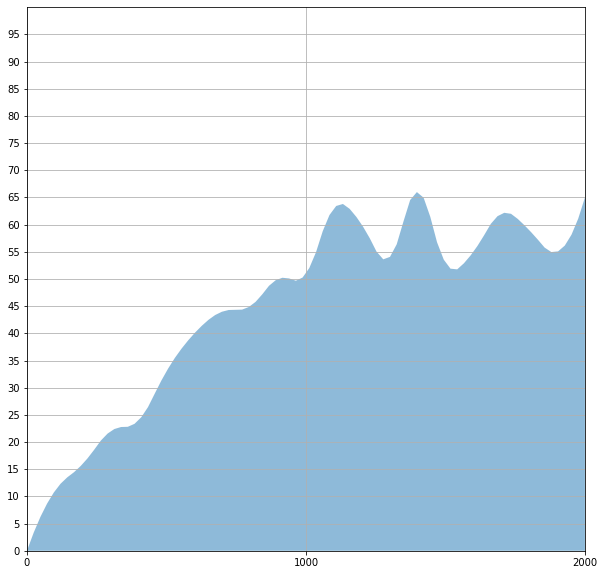

In [21]:
train = run_DQN(2000)